# Reddit Gilded Comments Word Cloud

## Resources

* https://www.reddit.com/about/alien/
* https://www.reddit.com/wiki/licensing

**Warning this query is expensive:** This query will process 954.8 GB when run.

    SELECT author, body, gilded
    FROM `fh-bigquery.reddit_comments.20*`
    WHERE gilded > 9

In [155]:
%matplotlib inline
#%load_ext signature
import os

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import spacy

from collections import Counter

from PIL import Image
from imageio import imread
from wordcloud import WordCloud, STOPWORDS

#import helpers

mask = imread('../img/reddit-alien-large-mask.png')
mpl.style.use('light')
nlp = spacy.load("en_core_web_lg")

chartinfo = 'Author: Ramiro Gómez - ramiro.org • Data: Reddit /u/Stuck_In_the_Matrix & /u/fhoffa - reddit.com'
font = '/usr/share/fonts/truetype/ubuntu-font-family/Ubuntu-B.ttf'
limit = 500
title = 'Most frequent words in reddit comments gilded 10 times or more'
footer = 'The {} most frequent words, excluding English stopwords, in reddit comments that where gilded 10 or more times from 2005 until February 2019.\n{}'.format(limit, chartinfo)

df = pd.read_csv(os.path.expanduser('~/data/reddit/reddit_comments_gilded_min_10_20190428.csv'))
df.head()

,author,body,gilded
0,YokeDaddySupreme,"No, apparently they don’t give out Medals for ...",10
1,Coold0wn,You look like the guy I know that went to get ...,10
2,goosegoosegoosegoose,I had just moved into a newly constructed home...,10
3,Deimorz,"Hey everyone, thanks for all the kind words. I...",10
4,jstrydor,"hey OP, I know you probably think what you're ...",10


In [24]:
#texts = df.body.apply(lambda s: textacy.preprocess_text(s, lowercase=True, no_urls=True)).str.cat(sep=' ')
texts = df.body.str.cat(sep=' ').lower()

wc = WordCloud(
    max_words=limit, 
    mask=mask, 
    stopwords=set(STOPWORDS), 
    background_color='#ffffff',
    font_path=font).generate(texts)

(-0.5, 719.5, 999.5, -0.5)

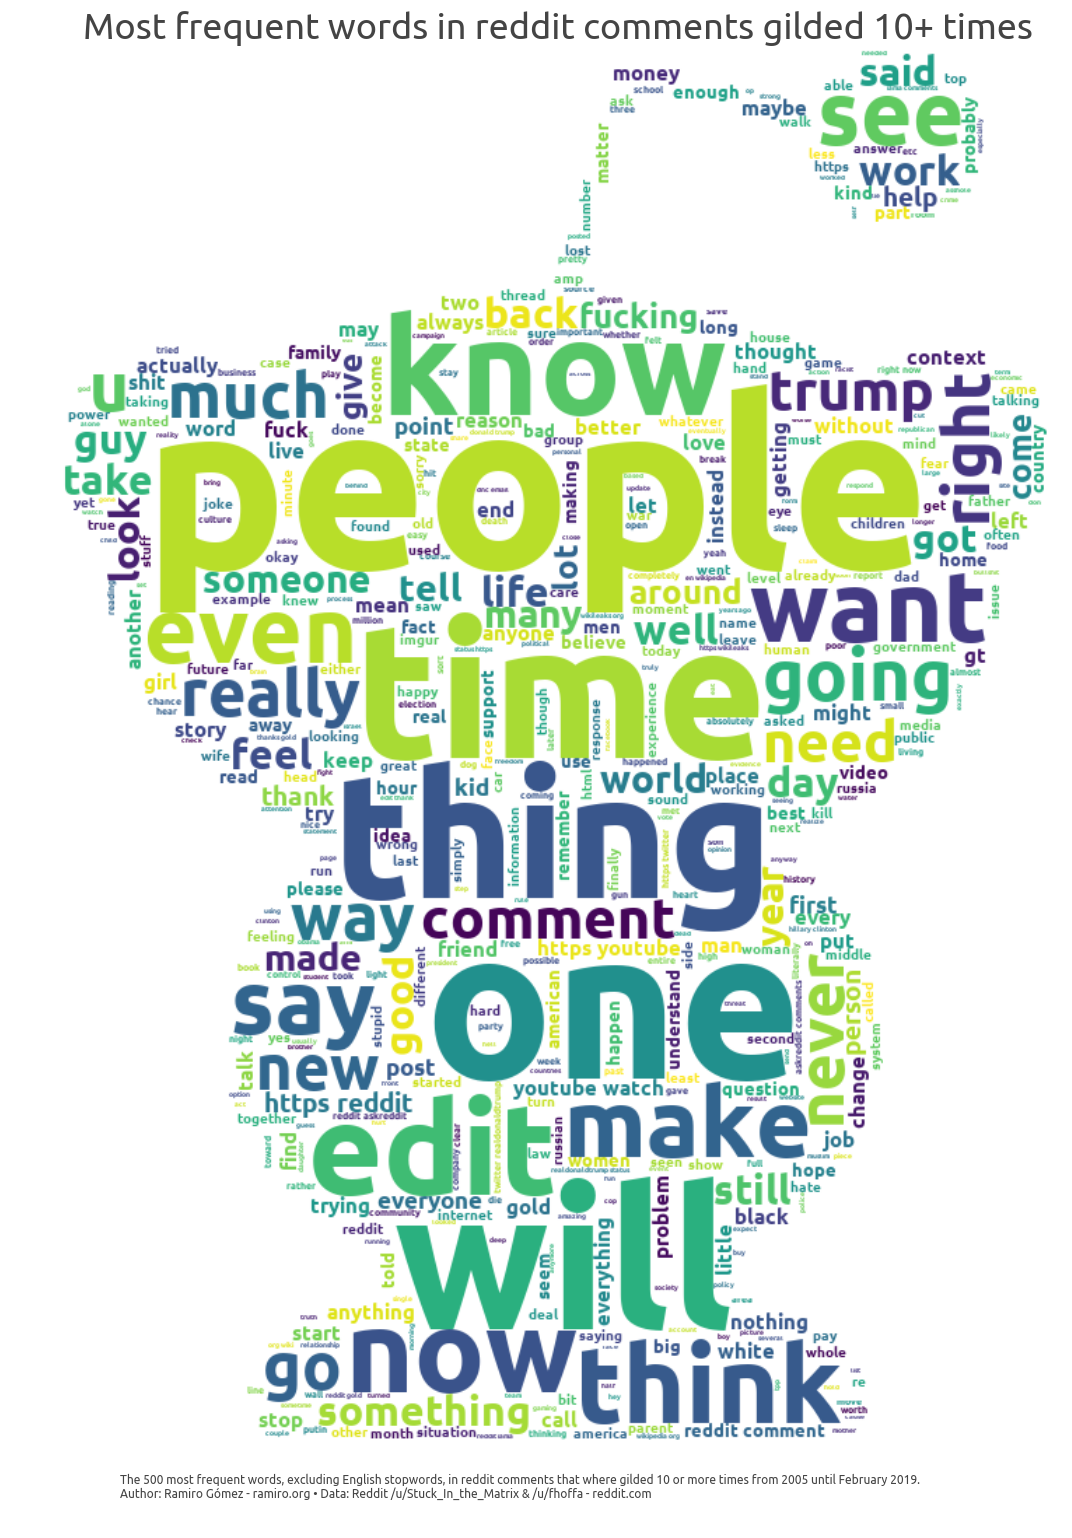

In [25]:
fig = plt.figure()
fig.set_figwidth(18)
fig.set_figheight(24)

plt.imshow(wc, interpolation='bilinear')
plt.title(title, fontsize=36)
plt.annotate(footer, xy=(120, 40), xycoords='figure points', fontsize=12)
plt.axis('off')

#plt.savefig('../img/gilded-comments-wordcloud-reddit-alien.png', bbox_inches='tight')

In [8]:
#%signature

In [192]:
exclude = ('’', '“', '”', '%', '_', '–', 'R', 'r', 's'
words = []
tokens = [] # DEBUG

for idx, text in df.body.items():
    doc = nlp(text)
    for token in doc:
        if token.is_stop or not len(token.text) or token.text in exclude or token.lemma_ in exclude:
            continue
        tokens.append(token)
        if token.pos_ in ('ADV', 'VERB', 'NOUN'):
            words.append(token.lemma_)
        elif token.pos_ in ('PRON', 'ADJ'):
            if token.text in ('i', 'I'):
                words.append(token.text.upper())
            else:
                words.append(token.text.lower())
        elif token.pos_ == 'PROPN':
            words.append(token.text.upper())

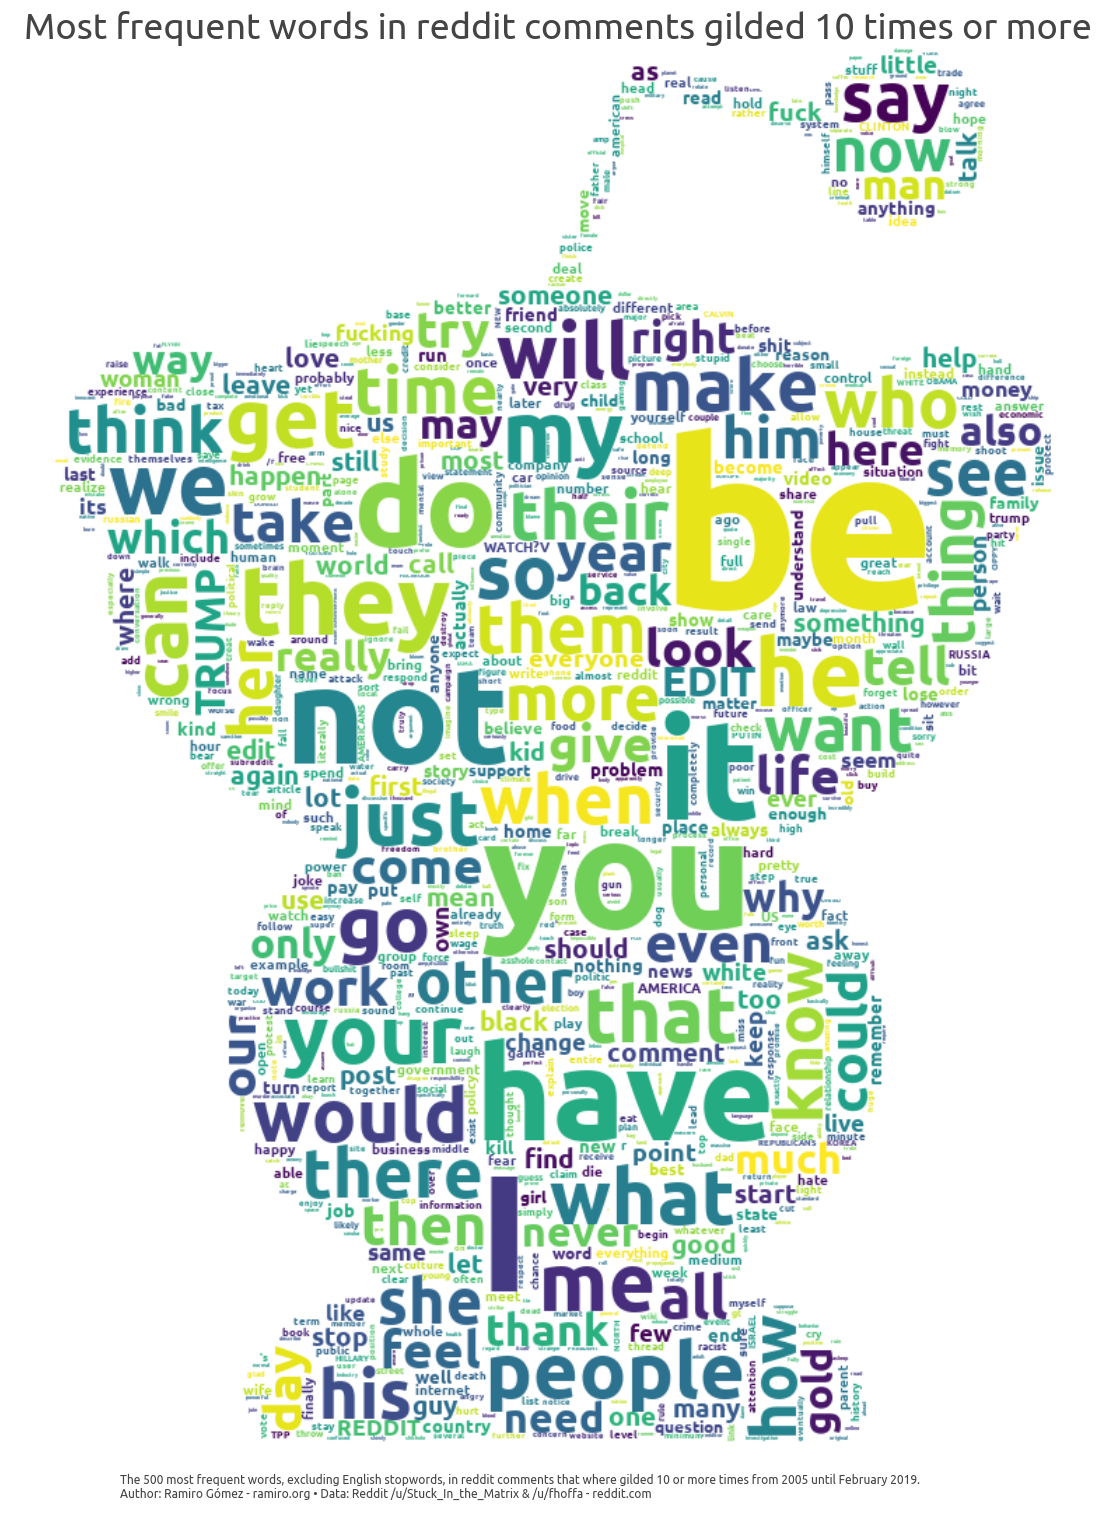

In [207]:
freq = Counter(words)
wc = WordCloud(
    max_words=1000, 
    mask=mask,
    background_color='#ffffff',
    font_path=font).fit_words(freq)

fig = plt.figure()
fig.set_figwidth(18)
fig.set_figheight(24)

plt.imshow(wc, interpolation='bilinear')
plt.title(title, fontsize=36)
plt.annotate(footer, xy=(120, 40), xycoords='figure points', fontsize=12)
plt.axis('off')

plt.savefig('../img/gilded-comments-wordcloud-reddit-alien.png', bbox_inches='tight')

In [209]:
#[token for token in freq.most_common(1000) if token[0].upper() == token[0]]
[token for token in freq.most_common(1000) if len(token[0]) == 1]

[('I', 4728), ('r', 114), ('”', 99), ('–', 32), ('s', 30), ('R', 23)]